# Trajectory Inference and Pseudotime

<style>
    .large-link {
        font-size: 30px;
        font-family: Arial, sans-serif;
        color: #333;
        text-decoration: none;
    }
</style>
<a href="../assets/pdf/11_pseudotime.pdf" target="_blank" class="large-link">Download Presentation: Pseudotime Trajectory Inference</a>

This notebook is partially adapted from the PAGA tutorial here:
[tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html)

## Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import scvelo as scv

import scipy
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=Warning)

## Reading data

First, we will load a dataset on [pancreatic endocrinogenesis](https://scvelo.readthedocs.io/en/stable/scvelo.datasets.pancreas.html) from a recent study:

[Bastidas-Ponce et al. "Comprehensive single cell mRNA profiling reveals a detailed roadmap for pancreatic endocrinogenesis." Development 2019.](https://doi.org/10.1242/dev.173849)

In [2]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

This dataset contains single cells from very early in mouse development at multiple cell stages. Given that we know the exact temporal ordering of the cells, this dataset is ideal for demonstrating the purpose of trajectory inference and pseudotemporal ordering of single cells.

In [3]:
adata.obs["clusters"].value_counts()

clusters
Ductal           916
Ngn3 high EP     642
Pre-endocrine    592
Beta             591
Alpha            481
Ngn3 low EP      262
Epsilon          142
Delta             70
Name: count, dtype: int64

**Exercise 1**: We must first quickly perform the standard steps of normalization, log-transformation, and PCA on the dataset. Can you do this using the functions you have learned to use in the previous exercises, and then plot the first two PCs, colored by the `clusters` metadata?

<button onclick="toggleVisibility('answer1')">Click for Answer</button>
<div id="answer1" style="display:none;">
<strong>Answer:</strong>
<pre>
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True)
    adata = adata[:, adata.var["highly_variable"]].copy()
    sc.tl.pca(adata)
    sc.pl.pca(adata, color='clusters')
</pre>
    
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

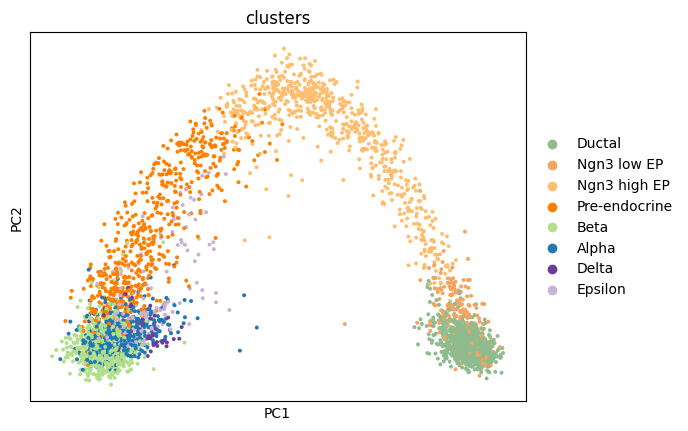

In [5]:
# your code here

Numerous trajectory inference methods, including PAGA, are graph-based. To obtain such a needed graph, we need to examine the nearest neighbors of each cell. Let's compute the neighborhood using 50 nearest neighbors and then embed the results on a UMAP.

In [6]:
sc.pp.neighbors(adata, n_pcs = 30, n_neighbors = 50)
sc.tl.umap(adata, min_dist=0.4, spread=3)

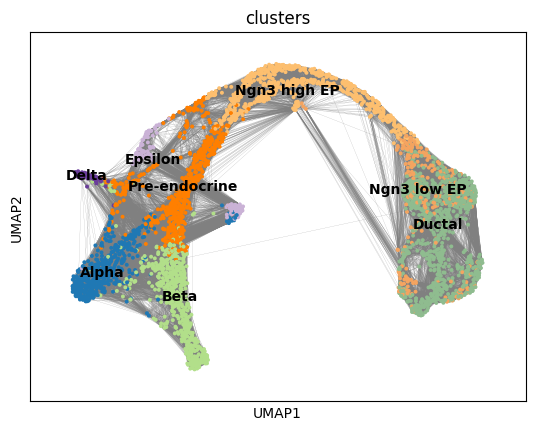

In [7]:
sc.pl.umap(adata, color = ['clusters'],
           legend_loc = 'on data', edges = True)

## Run PAGA

Use the ground truth cell types to run PAGA.
First we create the graph and initialize the positions using the umap.

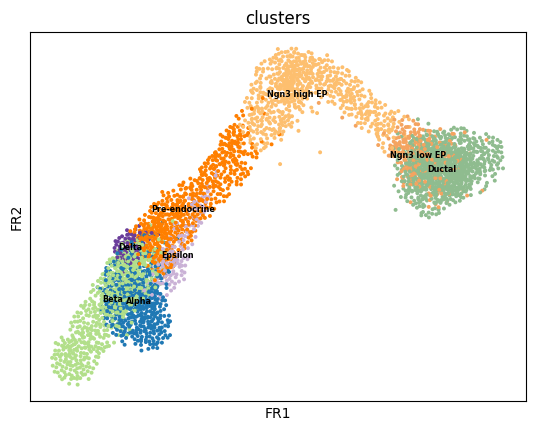

In [8]:
# use the umap to initialize the graph layout.
sc.tl.draw_graph(adata, init_pos='X_umap')
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data', legend_fontsize = 'xx-small')

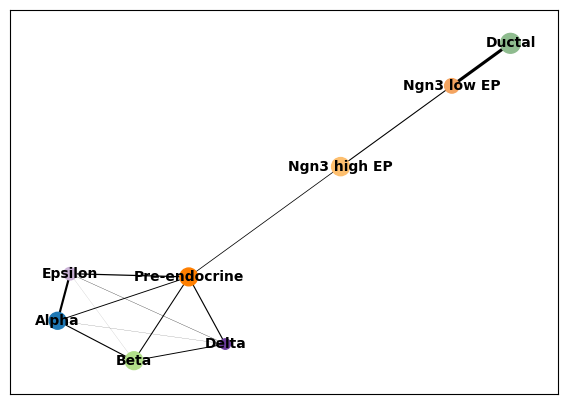

In [9]:
sc.tl.paga(adata, groups='clusters')
sc.pl.paga(adata, color='clusters', edge_width_scale = 0.3)

## Embedding using PAGA-initialization

We can now redraw the graph using another starting position from the
paga layout. The following is just as well possible for a UMAP.

In [10]:
sc.tl.draw_graph(adata, init_pos='paga')

Now we can see all marker genes also at single-cell resolution in a
meaningful layout.

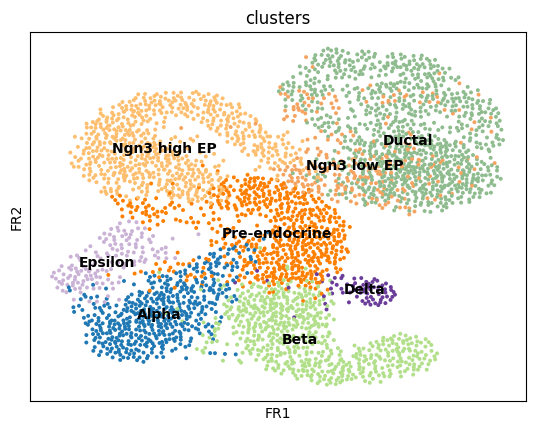

In [11]:
sc.pl.draw_graph(adata, color=['clusters'], legend_loc='on data')

## Gene changes

We can reconstruct gene changes along PAGA paths for a given set of
genes

Choose a "root" cell for diffusion pseudotime from the Ductal cells.

In [12]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['clusters']  == 'Ductal')[0]

**Exercise 2**: Next, use the `sc.tl.diffmap` and `sc.tl.dpt` functions to estimate a pseudotime. What does each of these functions specifically do?

<button onclick="toggleVisibility('answer2')">Click for Answer</button>
<div id="answer2" style="display:none;">
<strong>Answer:</strong>
<pre>
    sc.tl.diffmap(adata)
    sc.tl.dpt(adata)
</pre>
    
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

Visualize the results on the published embedding. You need to restore this because it was overwritten in your analyses above.

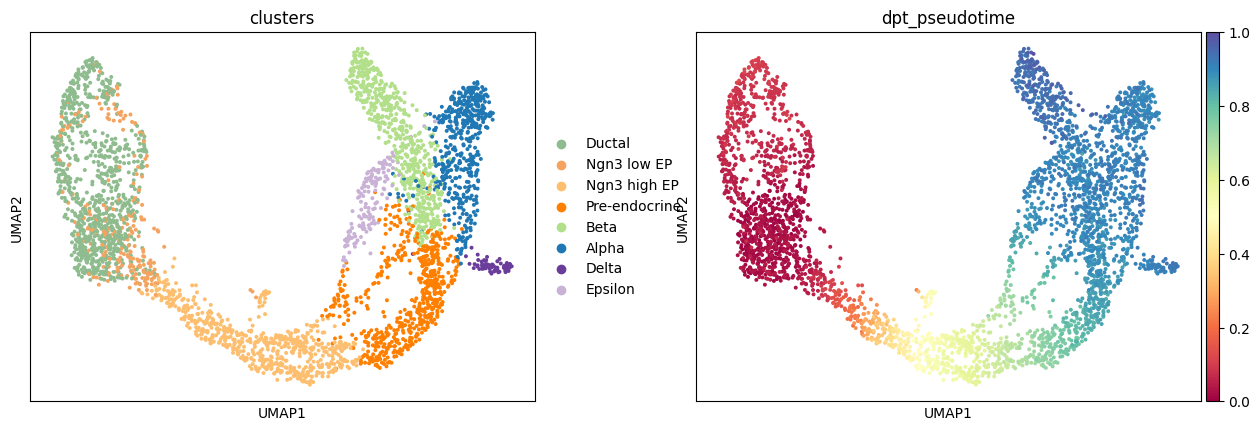

In [15]:
adata.obsm["X_umap"] = scv.datasets.pancreas().obsm["X_umap"]
sc.pl.umap(adata, color=['clusters', 'dpt_pseudotime'], cmap=plt.cm.Spectral, wspace=0.2)

By looking at the different know lineages and the layout of the graph we
define manually some paths to the graph that corresponds to specific
lineages.

In [17]:
# Define paths
paths = [('beta', ['Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Beta']),
        ('alpha', ['Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Alpha']),
        ('delta', ['Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Delta']),
        ('epsilon', ['Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Epsilon'])]

adata.obs['distance'] = adata.obs['dpt_pseudotime']

Then we select some genes that can vary in the lineages and plot onto
the paths.

In [18]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test", n_genes=10)

In [19]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"])

,Ductal,Ngn3 low EP,Ngn3 high EP,Pre-endocrine,Beta,Alpha,Delta,Epsilon
0,Spp1,Spp1,Neurog3,Map1b,Pcsk2,Cpe,Rbp4,Ghrl
1,Dbi,Dbi,Btbd17,Fev,Rbp4,Tmem27,Hhex,Isl1
2,Cldn3,Sparc,Sox4,Hmgn3,Mafb,Pcsk1n,Hmgn3,Rbp4
3,Mgst1,Mgst1,Mdk,Bex2,Sec61b,Tspan7,Isl1,Bex2
4,Anxa2,1700011H14Rik,Gadd45a,Ypel3,Cpe,Meis2,Fam183b,Fam183b
5,Bicc1,Cldn3,Smarcd2,Chga,Gng12,Gpx3,Hadh,Maged2
6,Krt18,Anxa2,Btg2,Emb,Pcsk1n,Fam183b,Arg1,Cck
7,Mt1,Clu,Tmsb4x,Cpe,Rap1b,Slc38a5,Sst,Anpep
8,Clu,Vim,Hes6,Cryba2,Tuba1a,Slc25a5,Gpx3,Card19
9,1700011H14Rik,Mt1,Cd63,Glud1,1700086L19Rik,Hmgn3,Dlk1,Arg1


In [22]:
gene_names = ["Spp1", "Dbi", "Cldn3", "Sparc", "Mgst1", "Cldn3", "Neurog3", "Btbd17", "Sox4",
              "Map1b", "Fev", "Hmgn3", "Bex2", "Sec61b", "Tuba1a", "Meis2", "Pcsk1n", "Sst", "Arg1",
              "Rbp4", "Hhex", "Ghrl", "Isl1", "Rbp4", "Bex2"]

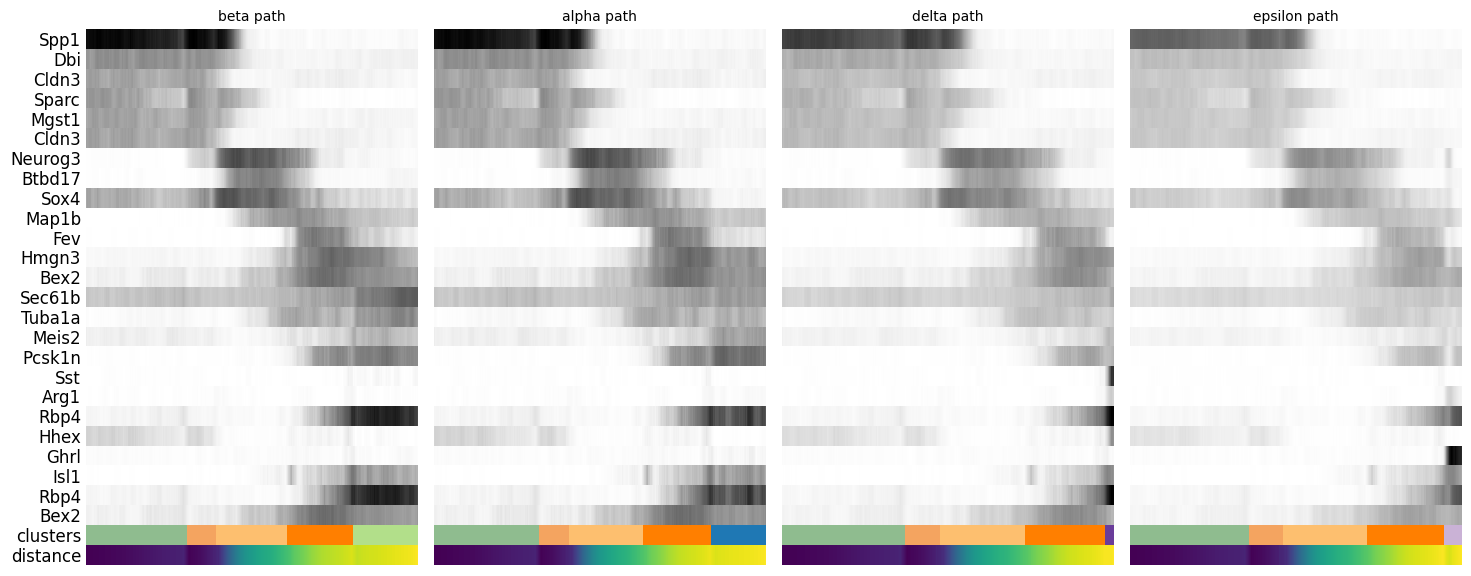

In [23]:
_, axs = pl.subplots(ncols=4, figsize=(16, 8), gridspec_kw={
                     'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath == 0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        use_raw=False,
        show=False)
pl.show()